In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Embedding, Bidirectional, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from transformers import *
from tokenizers import BertWordPieceTokenizer
from nltk.tokenize import word_tokenize

import os
import re
import string
import random
import time
import nltk, string
from tqdm import tqdm


In [2]:
train_df = pd.read_csv("../input/nlp-getting-started/train.csv")
test_df = pd.read_csv("../input/nlp-getting-started/test.csv")


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
len(train_df)

7613

In [6]:
len(test_df)

3263

<AxesSubplot:>

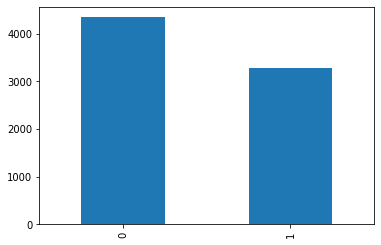

In [7]:
# distribution of target
train_df["target"].value_counts().plot.bar()

In [8]:
# the number of null values in keyword
train_df["keyword"].isnull().sum()

61

In [9]:
# the number of null values in location
train_df["location"].isnull().sum()

2533

In [10]:
# replace NaN values
train_df["keyword"] = train_df["keyword"].fillna("INVALIDkeyword")
test_df["keyword"] = test_df["keyword"].fillna("INVALIDkeyword")
train_df["location"] = train_df["location"].fillna("INVALIDlocation")
test_df["location"] = test_df["location"].fillna("INVALIDlocation")

In [11]:
tqdm(nltk.download('punkt'))
punct = string.punctuation
stopwords = nltk.corpus.stopwords.words()
wl = nltk.WordNetLemmatizer()

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


0it [00:00, ?it/s]


In [12]:
# remove punctuation and other unnecessary characters
def help(text):
    text = text.lower()
    text = "".join(word for word in text if word not in punct)
    text = re.split("\W+", text)
    text = " ".join(wl.lemmatize(word) for word in text if word not in stopwords)
    return text
train_df["refine_text"] = train_df["text"].apply(lambda x: help(x))
test_df["refine_text"] = test_df["text"].apply(lambda x: help(x))


In [13]:
vocab_size = 10000
embedding_dim = 16
max_len = 150
trunc_type = "post"
oov_tok = "<OOV>"
training_size = 20000

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_df["refine_text"])
word_index = tokenizer.word_index

In [14]:
train_word_sequence = tokenizer.texts_to_sequences(train_df["refine_text"])
train_padd_sequence = pad_sequences(train_word_sequence, maxlen=max_len, truncating=trunc_type)

test_word_sequence = tokenizer.texts_to_sequences(test_df["refine_text"])
test_padd_sequence = pad_sequences(test_word_sequence, maxlen=max_len, truncating=trunc_type)

In [15]:
tfidf_vect= CountVectorizer()
x_feature_keyword = tfidf_vect.fit_transform(train_df["keyword"])
x_feature_keyword = x_feature_keyword.toarray()

x_test_keyword = tfidf_vect.transform(test_df["keyword"])
x_test_keyword = x_test_keyword.toarray()

In [16]:
X_features = pd.concat([pd.DataFrame(x_feature_keyword), pd.DataFrame(train_padd_sequence)],axis=1)
X_test_features = pd.concat([pd.DataFrame(x_test_keyword), pd.DataFrame(test_padd_sequence)],axis=1)
X_features.head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,4031,448,156,68,1404,4032,13
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,106,3,148,6056,6057,1064
2,0,0,0,0,0,0,0,0,0,0,...,1405,1883,449,6058,317,162,1883,449,360,952
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2549,9,4033,75,162,360,32
4,0,0,0,0,0,0,0,0,0,0,...,0,42,1065,111,6059,1536,186,75,6060,93


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X_features, train_df["target"], test_size = 0.2)

In [18]:
model = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len+2),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dense(64, activation = "relu"),
    Dense(1, activation = "sigmoid")
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 152, 16)           160000    
_________________________________________________________________
bidirectional (Bidirectional (None, 152, 128)          41472     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 308,609
Trainable params: 308,609
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(optimizer="adam", loss = tf.keras.losses.binary_crossentropy, metrics = ["accuracy"])
history = model.fit(X_train, y_train, validation_data = (X_val, y_val), epochs = 2)

Epoch 1/2
191/191 [==============================] - 203s 1s/step - loss: 0.5620 - accuracy: 0.6962 - val_loss: 0.4506 - val_accuracy: 0.7938
Epoch 2/2
191/191 [==============================] - 193s 1s/step - loss: 0.3333 - accuracy: 0.8693 - val_loss: 0.4542 - val_accuracy: 0.7919


In [20]:
sample_sub=pd.read_csv("../input/nlp-getting-started/sample_submission.csv")
y_pred = model.predict(X_test_features).reshape(len(sample_sub))
y_pred = np.round(y_pred).astype(int)
sub=pd.DataFrame({"id":sample_sub["id"].values.tolist(),"target":y_pred})
sub.to_csv("submission.csv",index=False)

In [21]:
sub.head(10)

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
5,12,1
6,21,0
7,22,0
8,27,0
9,29,0
